In [1]:
import csv
import os
import glob
import numpy
from PIL import ImageDraw 
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageFont

def loadResizeImage(img_path, label=None):
    size = (124, 124)

    # Load the image
    img = Image.open(img_path)
    # Keep the original image size
    old_size = img.size

    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)

    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    if label != None:
        draw = ImageDraw.Draw(new_img)
        font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", 12)
        draw.text((62, 10),label,(255,255,255),font=font)

    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)

    return new_img

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images, indeces


In [24]:
# !pip3 install xlsxwriter

     |████████████████████████████████| 149 kB 877 kB/s            


In [45]:
import xlsxwriter
import cv2
from io import BytesIO
# This sorts images based on timestamps. These are used to manually annotate the dataset.
topDir = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/*'
dirs = glob.glob(topDir)
for dir in dirs:
    img, indeces = listDirs(dir)
    # Create an new Excel file and add a worksheet.
    workbook = xlsxwriter.Workbook('./tracklets/{}.xlsx'.format(dir.split('/')[-1]))
    worksheet = workbook.add_worksheet()
    sheetFormat = workbook.add_format({'text_wrap': True})
    # Widen the first column to make the text clearer.
    worksheet.set_column('A:A', 30, sheetFormat)
    worksheet.set_column('B:B', 17)
    for i in range(len(img)):
        # Insert an image.
        worksheet.set_row(i, 92)
        success, img_numpy = cv2.imencode('.jpg', loadResizeImage(img[i], label=str(i)))
        worksheet.write('A{}'.format(i), img[i])
        worksheet.insert_image('B{}'.format(i), img[i], {'image_data': BytesIO(img_numpy.tobytes())})
    workbook.close()

/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/xlsxwriter/worksheet.py:1418: UserWarning: Cannot insert image at (-1, 1).
  warn('Cannot insert image at (%d, %d).' % (row, col))


In [ ]:
# topDir = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/*'
# dirs = glob.glob(topDir)
# for dir in dirs:
#     img, indeces = listDirs(dir)
#     fig, ax = plt.subplots(1, figsize=((len(img) * 124)/500, 124/500), dpi=500)
#     img = [loadResizeImage(img[i], label=str(i)) for i in range(len(img))]
#     plt.imshow(compose(img, 1), aspect=1)
#     [ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
#     ax.axes.get_xaxis().set_ticks([])
#     ax.axes.get_yaxis().set_ticks([])
#     ax.axis("tight")
#     # print("{} {}".format(dir, len(img)))
#     plt.savefig("./tracklets/{}.png".format(dir.split('/')[-1]), dpi=500)
#     plt.figure().clear()
#     plt.close()
#     plt.cla()
#     plt.clf()
#     # break

In [118]:
import glob
import csv
import numpy
import json

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images, indeces

topDir = './tracklets/train/csv/*'
dirs = glob.glob(topDir)
dataSet = {"test": [], "train": [], "valid": []}
ignoreIndex = 20
for dir in dirs:
    # Parse the train data
    with open(dir) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        data = []
        trackletInd = []
        for row in csv_reader:
            row[0] = row[0].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '')
            category = int(row[0].split('/')[-2])
            if category < ignoreIndex:
                data.append([row[0], category, int(row[1])])
                trackletInd.append(int(row[1]))
        
        # dataRow = [] * len(numpy.unique(trackletInd))
        dataRow = []
        for i in range(len(numpy.unique(trackletInd))):
            dataRow += [{'paths':[], 'label': ''}]
        for path, category, tracklet in data:
            dataRow[tracklet]['label'] = category
            dataRow[tracklet]['paths'].append(path)
        # Why does this bugs out!?
        # dataRow = [{'paths':[], 'label': ''}] * len(numpy.unique(trackletInd))
        # for path, category, tracklet in data:
        #     print(path, category, tracklet)
        #     dataRow[tracklet]['label'] = category
        #     dataRow[tracklet]['paths'].append(path)
        # print(dataRow)
        # print(dataRow, data, numpy.unique(trackletInd))
        dataSet['train'] += dataRow

topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/'
with open('utils/openCows2020_test_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                if int(file['cowID']) < ignoreIndex:
                    sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                    dataSet['test'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            if int(file['cowID']) < ignoreIndex:
                directories, indeces = listDirs(topDIR + file['cowID'])
                directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
                dataSet['test'].append({"label": int(file['cowID']), "paths": directories})

In [119]:
import json
# Save
with open('./utils/opencowsTracklets2020V2.json', 'w') as fp:
    json.dump(dataSet, fp)

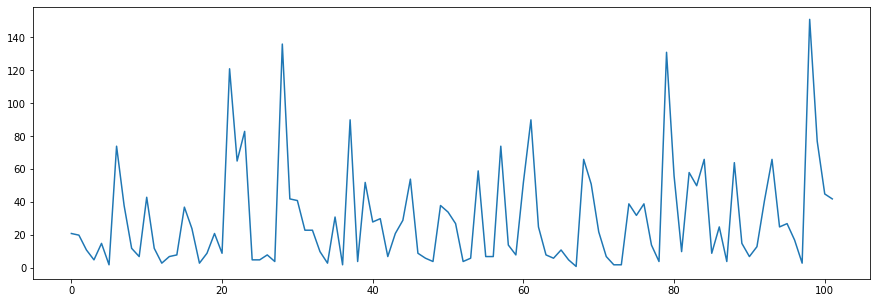

In [120]:
dt = [len(track['paths']) for track in dataSet['train']]
plt.plot(dt)

In [14]:
import json
topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/train/'
dataSet = {"test": [], "train": [], "valid": []}
with open('utils/openCows2020_train_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                dataSet['train'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            directories, indeces = listDirs(topDIR + file['cowID'])
            directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
            dataSet['train'].append({"label": int(file['cowID']), "paths": directories})

topDIR = '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/test/'
with open('utils/openCows2020_test_tracklet.json') as f:
    files = json.load(f)
    for file in files:
        if file['type'] == 'split':
            directories, indeces = listDirs(topDIR + file['cowID'])
            for split in file['splits']:
                sortedIdx = [directories[idx].replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for idx in split]
                dataSet['test'].append({"label": int(file['cowID']), "paths": sortedIdx})
        else:
            directories, indeces = listDirs(topDIR + file['cowID'])
            directories = [director.replace('/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/', '') for director in directories]
            dataSet['test'].append({"label": int(file['cowID']), "paths": directories})


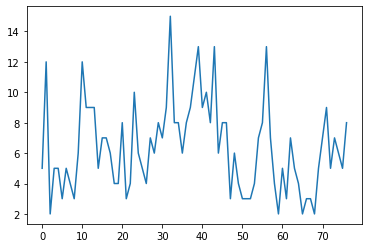

In [23]:
dt = [len(track['paths']) for track in dataSet['test']]
plt.plot(dt)

In [1]:
import csv
import os
import glob
import numpy

def listDirs(dir):
    images = glob.glob(dir + '/*')
    timestamps = [os.path.getctime(path) for path in images]
    indeces = numpy.argsort(timestamps)
    images = [images[idx] for idx in indeces]
    return images

topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB'
dataSet = {"test": [], "train": [], "valid": []}

# Parse the train data
with open('utils/correct.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0 and line_count < 465 and row[6] != 'black':
            label = row[4] if row[4] != '' else row[2]
            if label != '':
                dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(os.path.join(topDir, row[1]))]
                dataSet['train'].append({'label': int(label), 'paths': dirs})
        line_count += 1

# Parse the test data
labels = list(set([item['label'] for item in dataSet["train"]]))
topDir = '/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Test/'
for label in labels:
    path = os.path.join(topDir, '{:>03}'.format(label))
    dirs = [dir.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for dir in listDirs(path)]
    dataSet["test"].append({'label': int(label), 'paths': dirs})

# Since we omitted black cows we need to hot encode the labels again
labels = list(set([item['label'] for item in dataSet["train"]] + [item['label'] for item in dataSet["test"]]))
hotEncodeMap = {}
for i in range(len(labels)):
    hotEncodeMap[labels[i]] = i

# Now we can use the map the relabel the dataset
for split in dataSet.keys():
    for i in range(len(dataSet[split])):
        dataSet[split][i]['label'] = hotEncodeMap[dataSet[split][i]['label']]

In [95]:
labels = list(set([item['label'] for item in dataSet["train"]] + [item['label'] for item in dataSet["test"]]))
labels

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

5 5 5


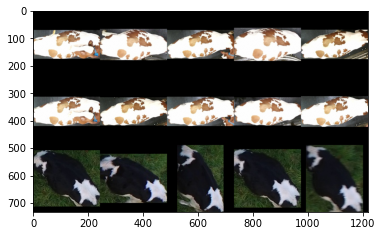

38


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

def loadResizeImage(img_path):
    size = (244, 244)
    # Load the image
    img = Image.open(img_path)

    # Keep the original image size
    old_size = img.size

    # Compute resizing ratio
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)

    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))

    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)

    return new_img

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

topDir = "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17"
for i in range(38, 39):
    # Sample image from the dataset
    trainSet = None
    testSet = None
    negSet = None
    for j in range(len(dataSet["train"])):
        if dataSet["train"][j]["label"] - 1 == i:
            trainSet = dataSet["train"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] - 1 == i:
            testSet = dataSet["test"][j]["paths"]
            break
    for j in range(len(dataSet["test"])):
        if dataSet["test"][j]["label"] - 1 == i+1:
            negSet = dataSet["test"][j]["paths"]
            break
    # Take first 5 images
    trainSet, testSet, negSet = [os.path.join(topDir, path) for path in trainSet[:5]], [
        os.path.join(topDir, path) for path in testSet[:5]
    ], [os.path.join(topDir, path) for path in negSet[:5]]

    trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
    negSet = [loadResizeImage(path) for path in negSet]
    print(len(trainSet), len(testSet), len(negSet))
    composite = compose([compose(trainSet, 1), compose(testSet, 1), compose(negSet, 1)], 0)
    plt.imshow(composite)
    plt.show()
    print(i)
    break

FileNotFoundError: [Errno 2] No such file or directory: '/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17/identification/images/train/*/identification/images/train/001/000142.jpg'

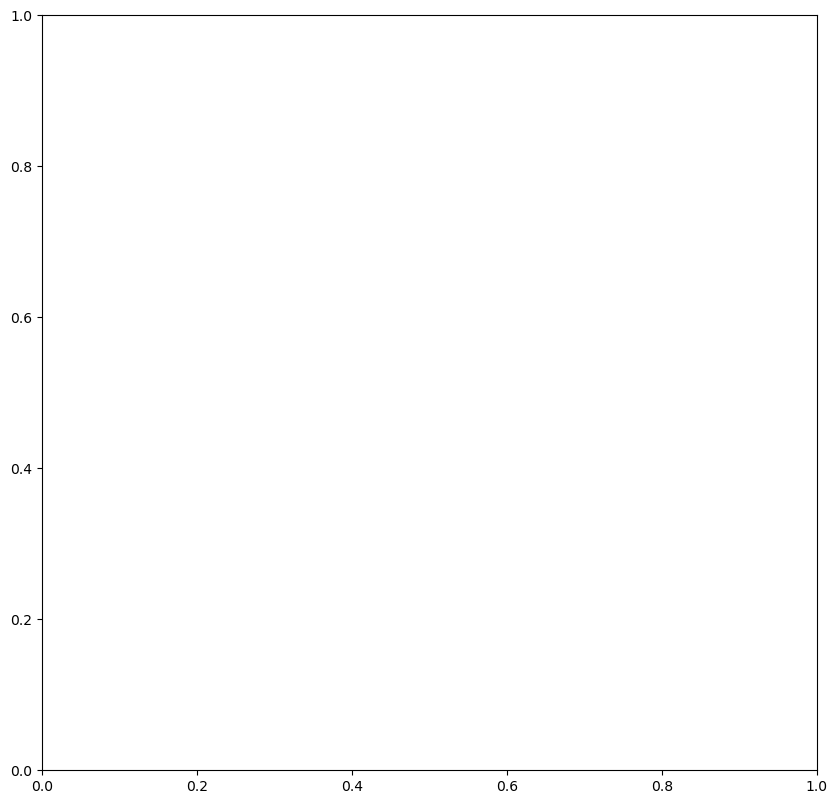

In [63]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=100)
found = []
for item in dataSet['train']:
    if item['label'] == 1:
        found.append(item)

# Take first 5 images
trainSet, testSet = [os.path.join(topDir, path) for path in found[0]['paths'][:5]], [
    os.path.join(topDir, path) for path in found[1]['paths'][:5]
]

trainSet, testSet = [loadResizeImage(path) for path in trainSet], [loadResizeImage(path) for path in testSet]
composite = compose([compose(trainSet, 1), compose(testSet, 1)], 0)
plt.imshow(composite)
plt.show()


In [3]:
import json
# Save
with open('./utils/opencowsTracklets2020V2.json', 'w') as fp:
    json.dump(dataSet, fp)

119.66666666666667

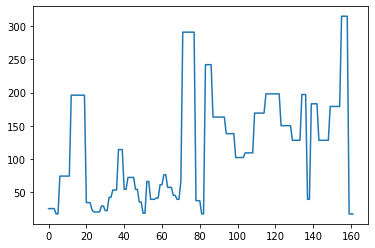

In [7]:
dt = [len(track['paths']) for track in dataSet['train']]
plt.plot(dt)
sum(dt) / len(dt)

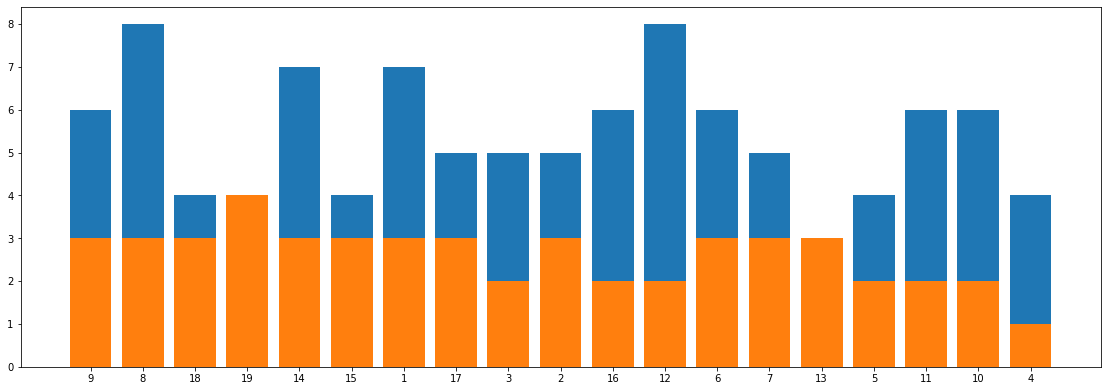

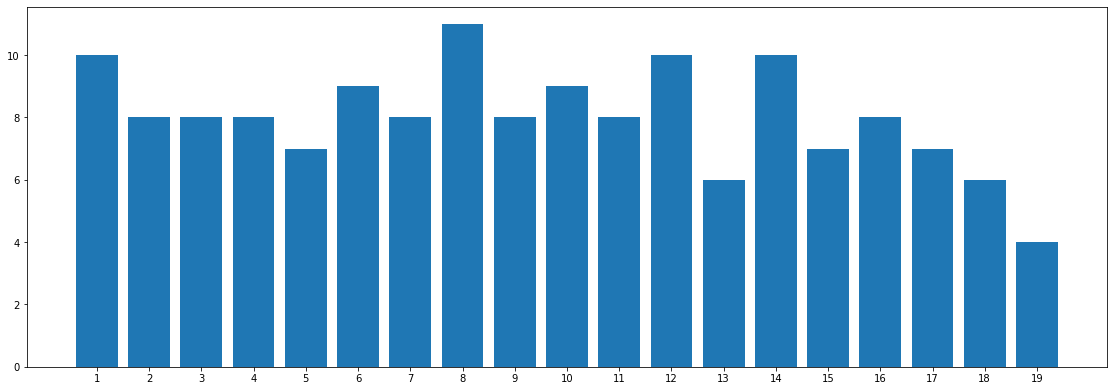

In [123]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet

dataset = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=False,
    split="train",
    trackletChoiceProb = 1,
)

dataset2 = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=False,
    split="test",
    trackletChoiceProb = 1,
)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

distribution = numpy.asarray([[k, len(dataset.lookup[k])] for k in dataset.lookup.keys()])
distribution2 = numpy.asarray([[k, len(dataset2.lookup[k])] for k in dataset2.lookup.keys()])
langs = [str(i) for i in distribution[:,0]]
students = distribution[:,1]
ax.bar(langs,students)
ax.bar(langs,distribution2[:,1])
plt.show()

dataset3 = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/10m32xl88x2b61zlkkgz3fml17",
    "utils/opencowsTracklets2020V2Combined.json",
    maxSequenceLength=None,
    # transform=False,
    split="train",
    trackletChoiceProb = 1,
)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
distribution = numpy.asarray([[k, len(dataset3.lookup[k])] for k in dataset3.lookup.keys()])
langs = [str(i) for i in distribution[:,0]]
students = distribution[:,1]
ax.bar(langs,students)
plt.show()

In [104]:
sequenceLengths = [[dataset3.__getitem__(ind)[0].shape[0] for ind in dataset3.lookup[k]] for k in dataset3.lookup.keys()]
sequenceLengths

[[5, 12, 2, 23, 10, 3, 31, 2, 90, 4],
 [5, 5, 3, 38, 34, 27, 4, 6],
 [5, 4, 3, 29, 54, 9, 6, 4],
 [6, 12, 9, 9, 151, 77, 45, 42],
 [9, 5, 7, 58, 50, 66, 9],
 [7, 6, 4, 66, 51, 22, 7, 2, 2],
 [4, 8, 3, 39, 32, 39, 14, 4],
 [4, 10, 6, 74, 38, 12, 7, 43, 12, 3, 7],
 [5, 4, 21, 20, 11, 5, 15, 2],
 [7, 6, 8, 41, 66, 25, 27, 17, 3],
 [7, 9, 25, 4, 64, 15, 7, 13],
 [15, 8, 52, 90, 25, 8, 6, 11, 5, 1],
 [8, 6, 8, 131, 56, 10],
 [9, 11, 13, 121, 65, 83, 5, 5, 8, 4],
 [9, 10, 8, 136, 42, 41, 23],
 [13, 6, 59, 7, 7, 74, 14, 8],
 [8, 8, 52, 28, 30, 7, 21],
 [3, 6, 8, 37, 24, 3],
 [4, 9, 21, 9],
 [3, 23],
 [3, 11, 4, 8, 2],
 [3, 5, 15],
 [4, 26, 3],
 [7, 33, 21],
 [8, 4, 62],
 [13, 61, 50, 3],
 [7, 3, 4, 46],
 [4, 21, 14, 2],
 [2, 5, 12],
 [5, 22, 13],
 [3, 3, 15],
 [7, 17, 37],
 [5, 36, 6],
 [4, 7, 4, 23],
 [2, 4, 13],
 [3, 3, 17],
 [3, 7, 15],
 [2, 3, 2, 12],
 [5, 8, 31],
 [7, 46, 5, 6],
 [9, 51, 25],
 [5, 15, 26],
 [7, 29, 32],
 [6, 40, 5],
 [5, 18, 21],
 [8, 66]]

In [30]:
import json, glob
topDIR = '/Users/as16542/Downloads/3owflku95bxsx24643cybxu3qh/*/*/*.jpg'
dataSet = {"test": [], "train": [], "valid": []}
images = glob.glob(topDIR)
images.sort()
currentCategory, currentTracklet = 0, 0
currentList, trackletImage = [], []
element = {}
categories = []
for directory in images:
    elements = directory.split('/')
    category, tracklet, image = int(elements[-3]), int(elements[-2]), elements[-1]
    if currentCategory != category or currentTracklet != tracklet:
        dataSet['train'].append({'paths': trackletImage, 'label': currentCategory})
        trackletImage = []
        categories.append(category)
        currentCategory = category
        currentTracklet = tracklet
    # if category > 1:
    #     break
    trackletImage.append(directory.replace('/Users/as16542/Downloads/3owflku95bxsx24643cybxu3qh/', ''))

def list_splitter(list_to_split, ratio):
    first_half = int(len(list_to_split) * ratio)
    return list_to_split[:first_half], list_to_split[first_half:]
dataSetFin = {"test": [], "train": [], "valid": []}
for category in list(set(categories)):
    tracklets = []
    for tracklet in dataSet['train']:
        if tracklet['label'] == category:
            tracklets.append(tracklet)
    train, test = list_splitter(tracklets, 0.9)
    dataSetFin['train'] += train
    dataSetFin['test'] += test

import json
# Save
with open('./utils/opencowsTracklets2017.json', 'w') as fp:
    json.dump(dataSetFin, fp)

In [32]:
set(categories)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22}

129


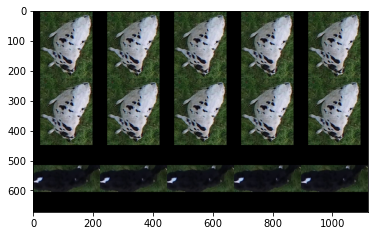

0 9
129


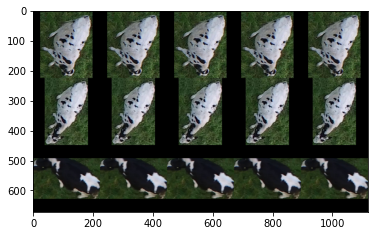

0 22
129


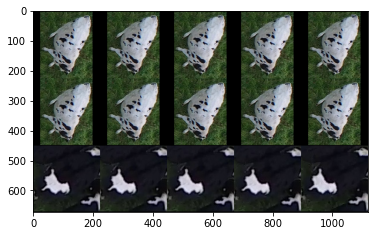

0 4
129


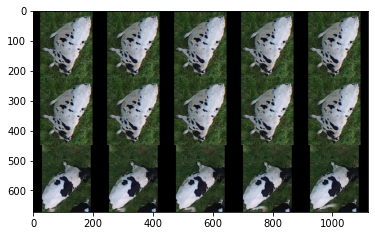

0 16
129


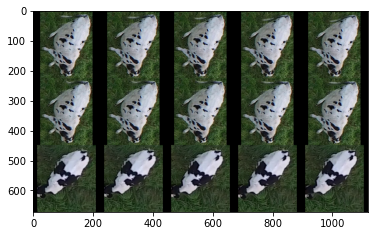

0 19
129


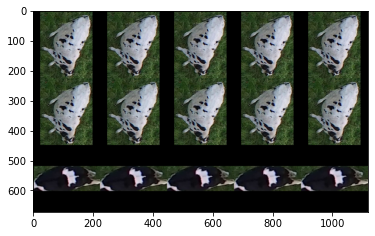

0 4
129


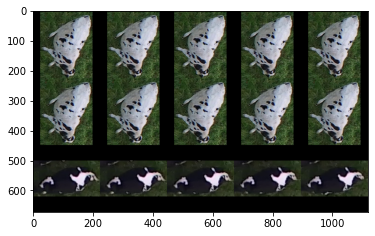

0 20
129


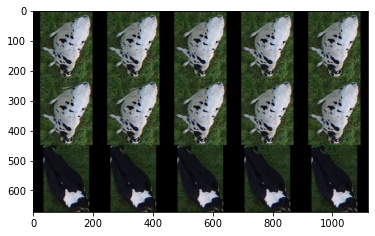

0 21
129


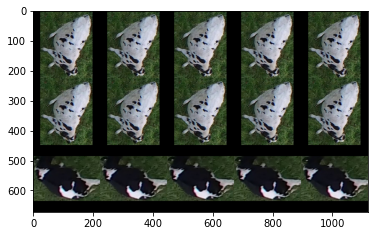

0 20
129


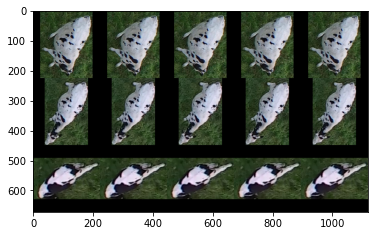

0 15
129


In [1]:
import json
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet
import matplotlib.pyplot as plt
import numpy

trainingDataset = OpenSetCows2021TrackLet(
    "/Users/as16542/Downloads/3owflku95bxsx24643cybxu3qh",
    'utils/opencowsTracklets2017.json',
    maxSequenceLength=5,
    split='train',
    trackletChoiceProb = 0.4,
    eval=True
)

print(len(trainingDataset))
for i in range(10):
    # Test
    negative, anchor, positive, positiveLabel, negativeLabel = trainingDataset.__getitem__(
        0
    )
    anc = [a.permute(1, 2, 0).numpy() for a in anchor]
    pos = [a.permute(1, 2, 0).numpy() for a in positive]
    neg = [a.permute(1, 2, 0).numpy() for a in negative]

    # Function to compose images in a grid
    compose = lambda images, horizontal: numpy.concatenate(
        [img if horizontal == 1 else img for img in images],
        axis=horizontal,
    )

    plt.imshow(compose([compose(anc, 1), compose(pos, 1), compose(neg, 1)], 0))
    plt.show()
    print(positiveLabel, negativeLabel)
    print(len(trainingDataset))

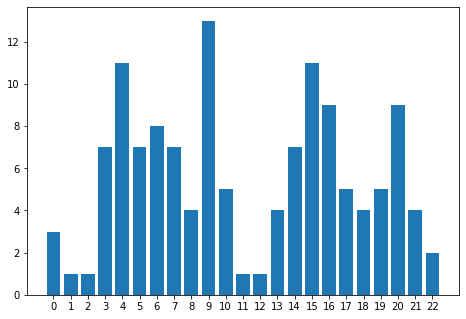

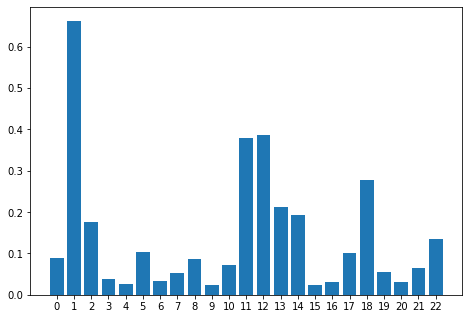

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
distribution = numpy.asarray([[k, len(trainingDataset.lookup[k])] for k in trainingDataset.lookup.keys()])
langs = [str(i) for i in distribution[:,0]]
students = distribution[:,1] 
ax.bar(langs,students)
plt.show()

with open('utils/opencowsTracklets2017.json') as f:
    dataSet = json.load(f)

classFrequency = numpy.zeros(len(langs))
for track in dataSet['train']:
    classFrequency[track['label']] += len(track['paths'])
for track in dataSet['test']:
    classFrequency[track['label']] += len(track['paths'])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
weights = (1 / classFrequency / sum(classFrequency))
# weights = (weights - weights.mean())/(weights.std())
weights = weights / numpy.linalg.norm(weights)
ax.bar(langs, weights)
plt.show()